In [1]:
import pandas as pd
import numpy as np
from astropy.units import Quantity
from astropy.cosmology import LambdaCDM
from astropy.coordinates import SkyCoord
from astropy import units as u
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import os
from tqdm import tqdm
import pickle

import xga
from xga.products.relation import ScalingRelation
from xga.relations.fit import scaling_relation_lira
from xga.imagetools.misc import rad_to_ang

In [2]:
cosmo = LambdaCDM(70, 0.3, 0.7)

In [3]:
# old = pd.read_csv("../thesis_mass_plots/thesis_sdss_meas.csv")

# oldnew = pd.merge(old, mass, on='name', how='left')

In [4]:
samp = pd.read_csv('xcs3p_sdssrm_clusters.csv')[['name', 'MEM_MATCH_ID', 'z', 'richness', 'richness_err']]
prop = pd.read_csv("sdssrm-xcs_r500_r2500_txlx.csv")
mass = pd.read_csv("sdssrm-xcs_masses.csv")

comb = pd.merge(samp, prop, on='name')
comb = pd.merge(comb, mass, on='name')
comb.head(10)

,name,MEM_MATCH_ID,z,richness,richness_err,Tx_500,Tx_500-,Tx_500+,Lx52_500,Lx52_500-,...,Mhy500_wraderr+,Mg500_wraderr,Mg500_wraderr-,Mg500_wraderr+,Mhy2500_wraderr,Mhy2500_wraderr-,Mhy2500_wraderr+,Mg2500_wraderr,Mg2500_wraderr-,Mg2500_wraderr+
0,SDSSXCS-124,124,0.247483,109.550186,4.489680,6.92015,0.116366,0.111646,5.310395e+44,2.513830e+42,...,1.041261,0.870390,0.015662,0.016223,2.621462,0.113380,0.138668,0.321697,0.007076,0.007250
1,SDSSXCS-2789,2789,0.105285,38.904396,2.830206,4.53982,0.073019,0.074566,1.029585e+44,6.177372e+41,...,1.456225,0.218499,0.002874,0.002963,1.602810,0.102195,0.110153,0.097399,0.001819,0.001737
2,SDSSXCS-290,290,0.348495,105.095730,5.994321,5.31695,0.297861,0.336333,2.856685e+44,5.981212e+42,...,0.420849,0.427478,0.019454,0.019887,1.469441,0.177871,0.288247,0.134133,0.005839,0.005993
3,SDSSXCS-1018,1018,0.214403,56.996796,3.219202,3.90154,0.143535,0.151506,8.044820e+43,8.099825e+41,...,0.973924,0.210059,0.003374,0.003431,1.128619,0.104011,0.149860,0.084350,0.002327,0.002330
4,SDSSXCS-134,134,0.277304,108.604380,4.792484,6.72636,0.116529,0.116561,4.811889e+44,2.353605e+42,...,0.781372,0.767157,0.010866,0.010814,3.042067,0.125878,0.124549,0.313911,0.007265,0.007068
5,SDSSXCS-119,119,0.304174,128.191760,5.697052,4.93463,0.400290,0.456170,2.049787e+44,5.881429e+42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,SDSSXCS-209,209,0.268822,101.709130,4.746494,8.02713,0.191895,0.211709,4.402865e+44,2.508109e+42,...,1.053528,0.792262,0.012094,0.011850,3.961525,0.202974,0.218888,0.338487,0.008766,0.008775
7,SDSSXCS-15,15,0.103966,123.355934,3.702013,2.59890,0.129067,0.139564,3.346001e+43,4.980330e+41,...,1.097964,0.143542,0.006865,0.005399,0.503225,0.120600,0.106530,0.047391,0.002449,0.002452
8,SDSSXCS-71,71,0.196102,112.921530,4.166370,5.79498,0.121290,0.116460,2.701121e+44,1.586443e+42,...,0.519588,0.874316,0.023003,0.023472,0.755730,0.236580,0.191532,0.179895,0.004614,0.004792
9,SDSSXCS-5020,5020,0.165803,30.468397,3.096611,3.97149,0.337615,0.390584,5.026336e+43,1.724955e+42,...,2.523749,0.065711,0.001522,0.001520,1.654287,0.259252,0.279500,0.041181,0.001753,0.001697


In [5]:
# plt.figure(figsize=(8, 8))
# plt.plot(oldnew['Mhy500'].values, oldnew['Mhy'].values, 'x')
# plt.show()

In [6]:
# plt.figure(figsize=(8, 8))
# plt.ylim(0, 1)
# plt.plot(oldnew['Mg500'].values/oldnew['Mg'].values, 'x')
# plt.show()

In [7]:
comb = comb[(comb['Mhy500_wraderr+'] < comb['Mhy500_wraderr']) & (comb['Mhy500_wraderr-'] < comb['Mhy500_wraderr'])]
comb = comb[~((comb['Mhy500_wraderr'] < 1) & (comb['Tx_500'] > 5))]
comb

,name,MEM_MATCH_ID,z,richness,richness_err,Tx_500,Tx_500-,Tx_500+,Lx52_500,Lx52_500-,...,Mhy500_wraderr+,Mg500_wraderr,Mg500_wraderr-,Mg500_wraderr+,Mhy2500_wraderr,Mhy2500_wraderr-,Mhy2500_wraderr+,Mg2500_wraderr,Mg2500_wraderr-,Mg2500_wraderr+
0,SDSSXCS-124,124,0.247483,109.550186,4.489680,6.92015,0.116366,0.111646,5.310395e+44,2.513830e+42,...,1.041261,0.870390,0.015662,0.016223,2.621462,0.113380,0.138668,0.321697,0.007076,0.007250
1,SDSSXCS-2789,2789,0.105285,38.904396,2.830206,4.53982,0.073019,0.074566,1.029585e+44,6.177372e+41,...,1.456225,0.218499,0.002874,0.002963,1.602810,0.102195,0.110153,0.097399,0.001819,0.001737
2,SDSSXCS-290,290,0.348495,105.095730,5.994321,5.31695,0.297861,0.336333,2.856685e+44,5.981212e+42,...,0.420849,0.427478,0.019454,0.019887,1.469441,0.177871,0.288247,0.134133,0.005839,0.005993
3,SDSSXCS-1018,1018,0.214403,56.996796,3.219202,3.90154,0.143535,0.151506,8.044820e+43,8.099825e+41,...,0.973924,0.210059,0.003374,0.003431,1.128619,0.104011,0.149860,0.084350,0.002327,0.002330
4,SDSSXCS-134,134,0.277304,108.604380,4.792484,6.72636,0.116529,0.116561,4.811889e+44,2.353605e+42,...,0.781372,0.767157,0.010866,0.010814,3.042067,0.125878,0.124549,0.313911,0.007265,0.007068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143,SDSSXCS-34,34,0.300713,20.033995,3.873894,3.51423,0.206020,0.217709,8.633458e+43,1.939628e+42,...,0.376983,0.286297,0.013940,0.013461,0.617065,0.077543,0.078922,0.066970,0.004087,0.004046
144,SDSSXCS-11154,11154,0.160062,29.064940,2.978542,4.15448,0.125320,0.125168,1.691834e+44,1.880848e+42,...,0.338649,0.393123,0.011202,0.010895,1.041306,0.090935,0.098537,0.111631,0.003300,0.003317
147,SDSSXCS-68,68,0.300570,126.330660,4.886888,7.21801,0.216922,0.242930,5.482636e+44,5.676998e+42,...,0.797112,0.866319,0.019615,0.019060,2.925836,0.214431,0.224624,0.309140,0.011104,0.010986
148,SDSSXCS-147,147,0.259350,104.470276,4.512718,6.64643,0.183147,0.183515,2.494743e+44,2.037780e+42,...,1.854716,0.558438,0.007220,0.007275,2.090275,0.123725,0.133519,0.203258,0.005389,0.005588


## Scaling relations

In [8]:
t_norm = Quantity(5, 'keV')
l_norm = Quantity(2e+44, 'erg/s')
m_norm = Quantity(4e+14, 'Msun')
gm_norm = Quantity(5e+13, 'Msun')
snr_norm = Quantity(9, '')
rich_norm = Quantity(80, '')

### SDSSRM-XCS

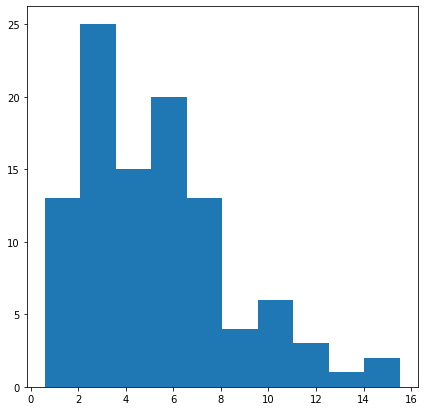

In [9]:
plt.figure(figsize=(7, 7))
plt.hist(comb['Mhy500_wraderr'])
plt.show()

In [10]:
Quantity(comb['Mhy500_wraderr'].min()*1e+14, 'Msun')

<Quantity 5.85102708e+13 solMass>

In [11]:
Quantity(comb['Mhy500_wraderr'].max()*1e+14, 'Msun')

<Quantity 1.55264712e+15 solMass>

In [12]:
e = cosmo.efunc(comb['z'].values)
ms = Quantity(comb[['Mhy500_wraderr', 'Mhy500_wraderr-', 'Mhy500_wraderr+']]*1e+14, 'Msun')*e[..., None]
ts = Quantity(comb[['Tx_500', 'Tx_500-', 'Tx_500+']], 'keV')
sdss_mt = scaling_relation_lira(ms[:, 0], ms[:, 1:], ts[:, 0], ts[:, 1:], m_norm, t_norm, 
                                y_name=r'$E(z)M^{\rm{hy}}_{500}$', x_name=r'$T_{\rm{X,500}}$')
sdss_mt.model_colour = 'tab:cyan'

R[write to console]: module mix loaded



  |**************************************************| 100%


/Users/dt237/code/XGA/xga/products/relation.py:827: UserWarning: The 'show_third_dim' argument should only be set to True if 'third_dim_info' was set on the creation of this scaling relation. Setting 'show_third_im' to False.
  warn("The 'show_third_dim' argument should only be set to True if 'third_dim_info' was set on the creation "


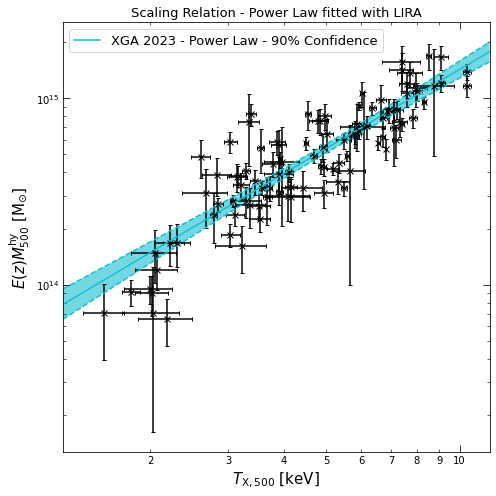

In [13]:
sdss_mt.view(figsize=(7, 7), save_path='sdssmt_r500.pdf')

Removed no burn in


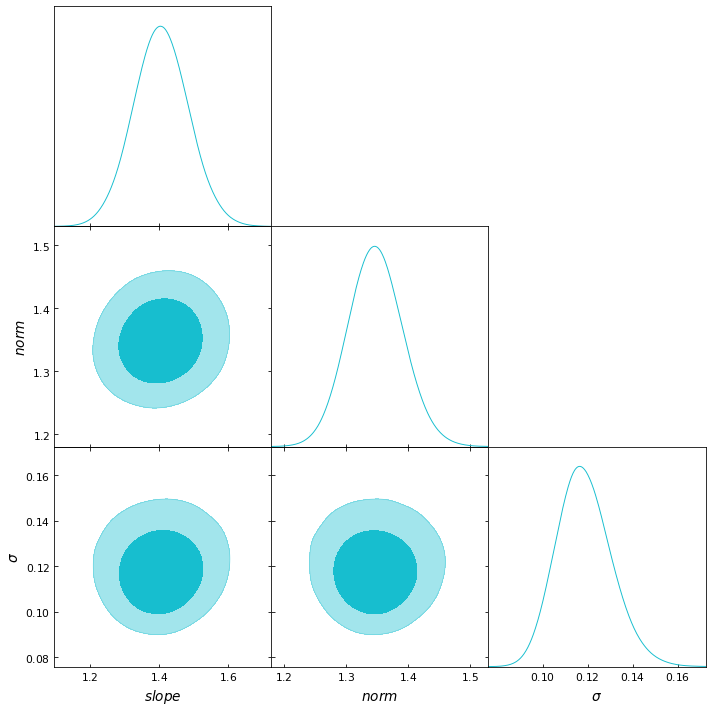

In [14]:
sdss_mt.view_corner()

In [15]:
e = cosmo.efunc(comb['z'].values)
ms = Quantity(comb[['Mhy500_wraderr', 'Mhy500_wraderr-', 'Mhy500_wraderr+']]*1e+14, 'Msun')*e[..., None]
ts = Quantity(comb[['Tx_500', 'Tx_500-', 'Tx_500+']], 'keV')
sdss_mt_wre = scaling_relation_lira(ms[:, 0], ms[:, 1:], ts[:, 0], ts[:, 1:], m_norm, t_norm, 
                                    y_name=r'$E(z)M^{\rm{hy}}_{500}$', x_name=r'$T_{\rm{X,500}}$', 
                                    third_dim_info=comb['z'].values, third_dim_name='Redshift')
sdss_mt_wre.model_colour = 'tab:cyan'

  |**************************************************| 100%


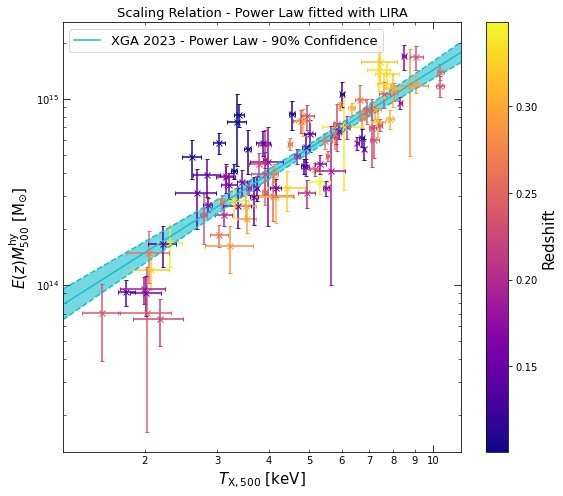

Removed no burn in


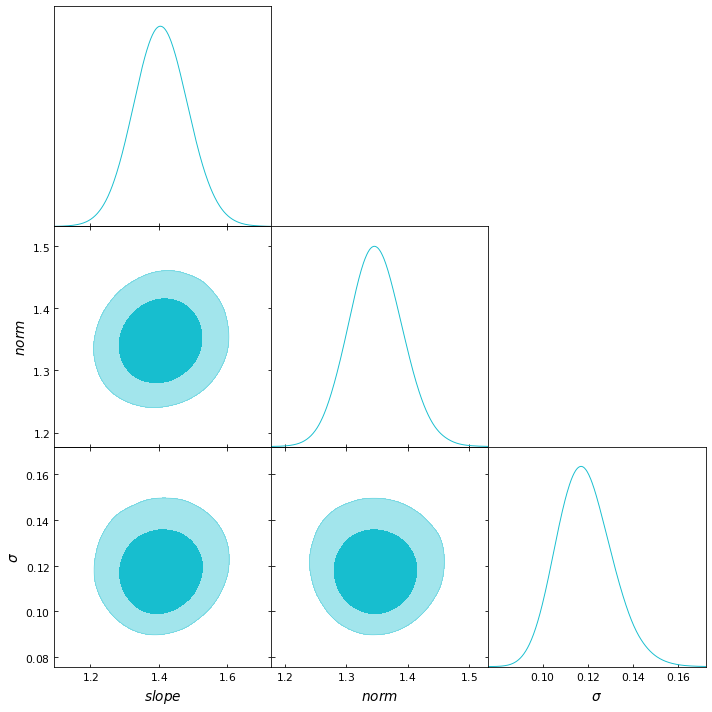

In [16]:
sdss_mt_wre.view(figsize=(8, 7))
sdss_mt_wre.view_corner()

In [17]:
e = cosmo.efunc(comb['z'].values)
ms = Quantity(comb[['Mhy2500', 'Mhy2500-', 'Mhy2500+']]*1e+14, 'Msun')*e[..., None]
ts = Quantity(comb[['Tx_2500', 'Tx_2500-', 'Tx_2500+']], 'keV')
sdss_mt2500 = scaling_relation_lira(ms[:, 0], ms[:, 1:], ts[:, 0], ts[:, 1:], m_norm, t_norm, 
                                y_name=r'$E(z)M^{\rm{hy}}_{2500}$', x_name=r'$T_{\rm{X,2500}}$')
sdss_mt2500.model_colour = 'tab:cyan'

/Users/dt237/code/XGA/xga/relations/fit.py:83: UserWarning: 13 sources have NaN values and have been excluded
  warn("{} sources have NaN values and have been excluded".format(thrown_away))


  |**************************************************| 100%


/Users/dt237/code/XGA/xga/products/relation.py:827: UserWarning: The 'show_third_dim' argument should only be set to True if 'third_dim_info' was set on the creation of this scaling relation. Setting 'show_third_im' to False.
  warn("The 'show_third_dim' argument should only be set to True if 'third_dim_info' was set on the creation "


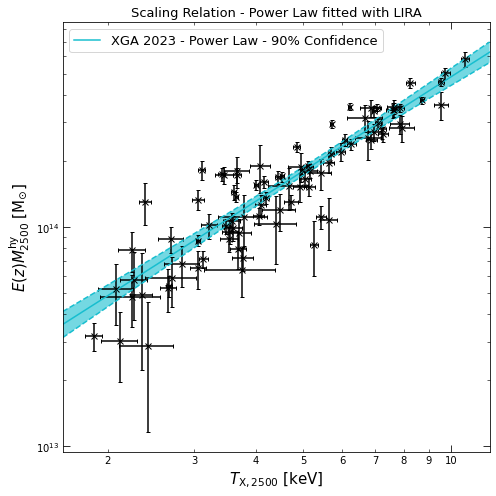

Removed no burn in


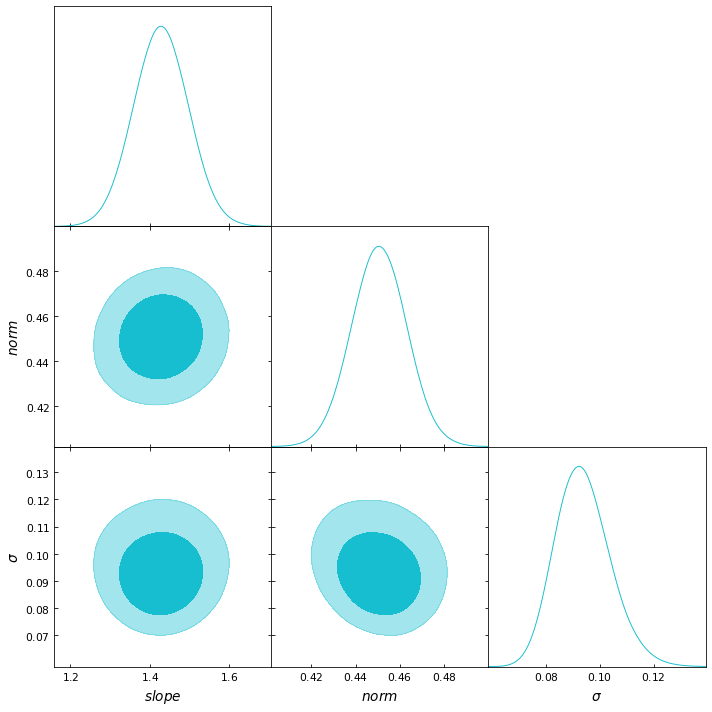

In [18]:
sdss_mt2500.view(figsize=(7, 7), save_path='sdssmt_r2500.pdf')
sdss_mt2500.view_corner()

In [30]:
ms = Quantity(comb[['Mhy2500_wraderr', 'Mhy2500_wraderr-', 'Mhy2500_wraderr+']]*1e+14, 'Msun')
mgs = Quantity(comb[['Mg2500_wraderr', 'Mg2500_wraderr-', 'Mg2500_wraderr+']]*1e+14, 'Msun')
sdss_mmg2500 = scaling_relation_lira(ms[:, 0], ms[:, 1:], mgs[:, 0], mgs[:, 1:], m_norm, Quantity(1e+13, 'Msun'), 
                                y_name=r'$M^{\rm{hy}}_{2500}$', x_name=r'$M^{\rm{g}}_{2500}$')
sdss_mmg2500.model_colour = 'tab:cyan'

/Users/dt237/code/XGA/xga/relations/fit.py:83: UserWarning: 13 sources have NaN values and have been excluded
  warn("{} sources have NaN values and have been excluded".format(thrown_away))


  |**************************************************| 100%


/Users/dt237/code/XGA/xga/products/relation.py:827: UserWarning: The 'show_third_dim' argument should only be set to True if 'third_dim_info' was set on the creation of this scaling relation. Setting 'show_third_im' to False.
  warn("The 'show_third_dim' argument should only be set to True if 'third_dim_info' was set on the creation "


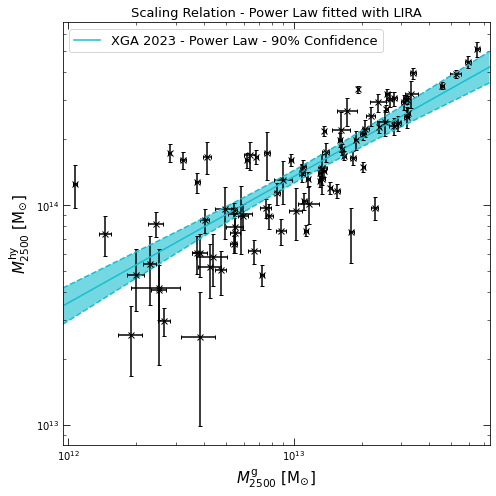

In [32]:
sdss_mmg2500.view(figsize=(7, 7), save_path='sdssmhymg_r2500.pdf')

In [21]:
testo = comb[comb['Mhy500_wraderr'] > 0.9]
testo

,name,MEM_MATCH_ID,z,richness,richness_err,Tx_500,Tx_500-,Tx_500+,Lx52_500,Lx52_500-,...,Mhy500_wraderr+,Mg500_wraderr,Mg500_wraderr-,Mg500_wraderr+,Mhy2500_wraderr,Mhy2500_wraderr-,Mhy2500_wraderr+,Mg2500_wraderr,Mg2500_wraderr-,Mg2500_wraderr+
0,SDSSXCS-124,124,0.247483,109.550186,4.489680,6.92015,0.116366,0.111646,5.310395e+44,2.513830e+42,...,1.041261,0.870390,0.015662,0.016223,2.621462,0.113380,0.138668,0.321697,0.007076,0.007250
1,SDSSXCS-2789,2789,0.105285,38.904396,2.830206,4.53982,0.073019,0.074566,1.029585e+44,6.177372e+41,...,1.456225,0.218499,0.002874,0.002963,1.602810,0.102195,0.110153,0.097399,0.001819,0.001737
2,SDSSXCS-290,290,0.348495,105.095730,5.994321,5.31695,0.297861,0.336333,2.856685e+44,5.981212e+42,...,0.420849,0.427478,0.019454,0.019887,1.469441,0.177871,0.288247,0.134133,0.005839,0.005993
3,SDSSXCS-1018,1018,0.214403,56.996796,3.219202,3.90154,0.143535,0.151506,8.044820e+43,8.099825e+41,...,0.973924,0.210059,0.003374,0.003431,1.128619,0.104011,0.149860,0.084350,0.002327,0.002330
4,SDSSXCS-134,134,0.277304,108.604380,4.792484,6.72636,0.116529,0.116561,4.811889e+44,2.353605e+42,...,0.781372,0.767157,0.010866,0.010814,3.042067,0.125878,0.124549,0.313911,0.007265,0.007068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143,SDSSXCS-34,34,0.300713,20.033995,3.873894,3.51423,0.206020,0.217709,8.633458e+43,1.939628e+42,...,0.376983,0.286297,0.013940,0.013461,0.617065,0.077543,0.078922,0.066970,0.004087,0.004046
144,SDSSXCS-11154,11154,0.160062,29.064940,2.978542,4.15448,0.125320,0.125168,1.691834e+44,1.880848e+42,...,0.338649,0.393123,0.011202,0.010895,1.041306,0.090935,0.098537,0.111631,0.003300,0.003317
147,SDSSXCS-68,68,0.300570,126.330660,4.886888,7.21801,0.216922,0.242930,5.482636e+44,5.676998e+42,...,0.797112,0.866319,0.019615,0.019060,2.925836,0.214431,0.224624,0.309140,0.011104,0.010986
148,SDSSXCS-147,147,0.259350,104.470276,4.512718,6.64643,0.183147,0.183515,2.494743e+44,2.037780e+42,...,1.854716,0.558438,0.007220,0.007275,2.090275,0.123725,0.133519,0.203258,0.005389,0.005588


In [22]:
ms = Quantity(testo[['Mhy500_wraderr', 'Mhy500_wraderr-', 'Mhy500_wraderr+']]*1e+14, 'Msun')
mgs = Quantity(testo[['Mg500_wraderr', 'Mg500_wraderr-', 'Mg500_wraderr+']]*1e+14, 'Msun')
sdss_mmg500 = scaling_relation_lira(ms[:, 0], ms[:, 1:], mgs[:, 0], mgs[:, 1:], m_norm, gm_norm, 
                                y_name=r'$M^{\rm{hy}}_{500}$', x_name=r'$M^{\rm{g}}_{500}$')
sdss_mmg500.model_colour = 'tab:cyan'

  |**************************************************| 100%


/Users/dt237/code/XGA/xga/products/relation.py:827: UserWarning: The 'show_third_dim' argument should only be set to True if 'third_dim_info' was set on the creation of this scaling relation. Setting 'show_third_im' to False.
  warn("The 'show_third_dim' argument should only be set to True if 'third_dim_info' was set on the creation "


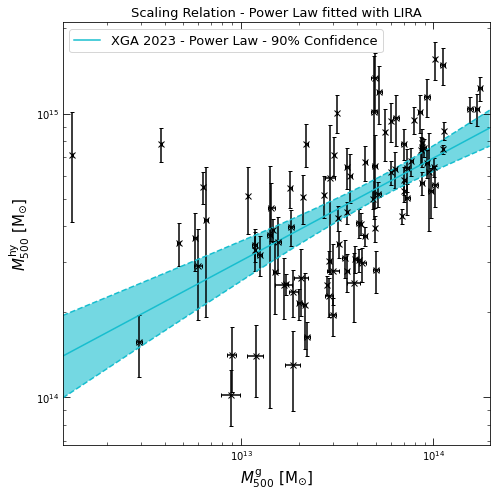

Removed no burn in


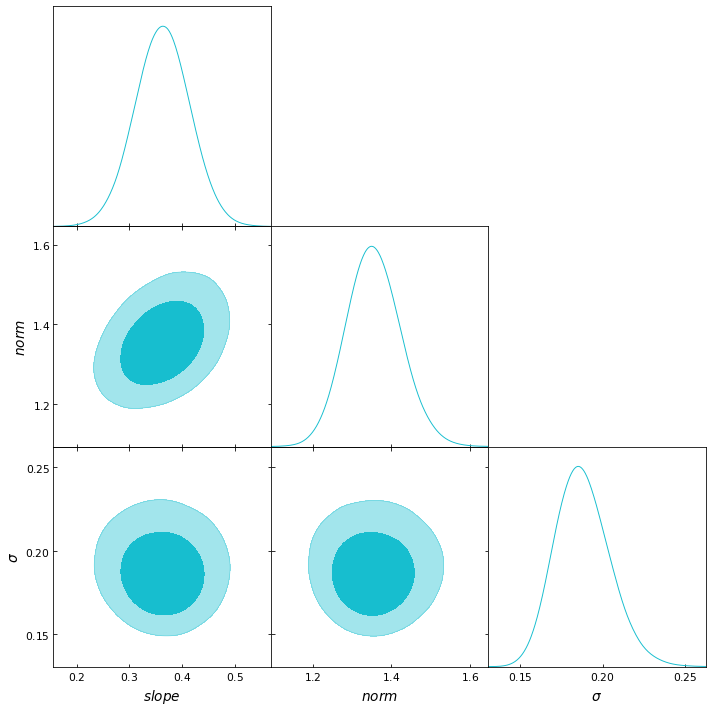

In [33]:
sdss_mmg500.view(figsize=(7, 7), save_path='sdssmhymg_r500.pdf')
sdss_mmg500.view_corner()

In [24]:
amt_pth = "/Users/dt237/code/mass_papers/XCS-Mass-Paper-I-Analysis/outputs/"\
    "scaling_relations/for_comparison/arnaud_mt.xgarel"
lmt_pth = "/Users/dt237/code/mass_papers/XCS-Mass-Paper-I-Analysis/outputs/"\
    "scaling_relations/for_comparison/lovisari_mt.xgarel"
lml_pth = "/Users/dt237/code/mass_papers/XCS-Mass-Paper-I-Analysis/outputs/"\
    "scaling_relations/for_comparison/lovisari_ml.xgarel"
amr_pth = "/Users/dt237/code/mass_papers/XCS-Mass-Paper-I-Analysis/outputs/"\
    "scaling_relations/for_comparison/andreon_mr.xgarel"

with open(amt_pth, 'rb') as reado:
    amt = pickle.load(reado)
    amt.model_colour = 'peru'
    amt._y_name = r'$E(z)M^{\rm{hy}}_{500}$'
    sdss_mt._x_name = amt.x_name

with open(lmt_pth, 'rb') as reado:
    lmt = pickle.load(reado)
    
with open(lml_pth, 'rb') as reado:
    lml = pickle.load(reado)
    
with open(amr_pth, 'rb') as reado:
    amr = pickle.load(reado)

In [25]:
amt.x_norm

<Quantity 5. keV>

In [26]:
amt.y_norm

<Quantity 4.e+14 solMass>

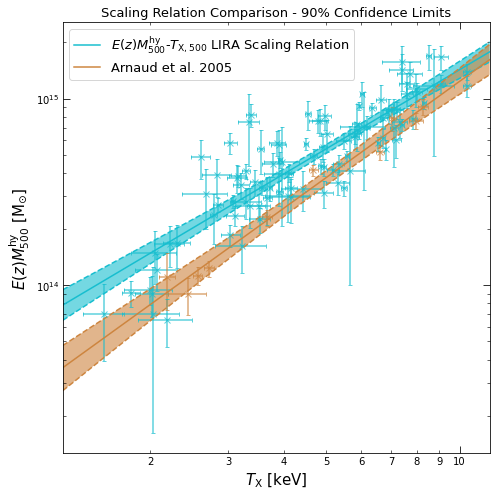

Removed no burn in
Removed no burn in


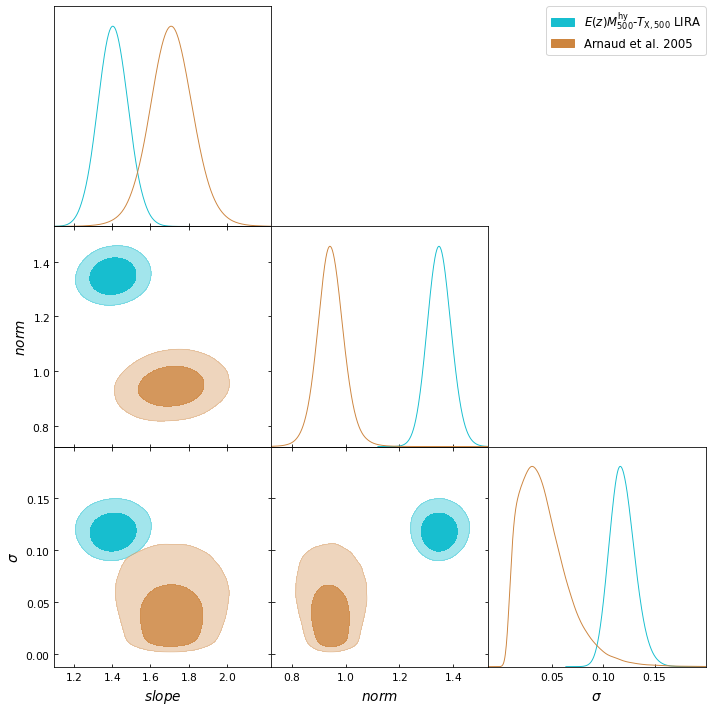

In [27]:
(sdss_mt+amt).view(figsize=(7, 7), save_path='sdss+arnaud_mt.pdf')
(sdss_mt+amt).view_corner()

/Users/dt237/code/XGA/xga/products/relation.py:1073: UserWarning: Not all of these ScalingRelations have the same x-axis names.
  warn('Not all of these ScalingRelations have the same x-axis names.')
/Users/dt237/code/XGA/xga/products/relation.py:1080: UserWarning: Not all of these ScalingRelations have the same y-axis names.
  warn('Not all of these ScalingRelations have the same y-axis names.')


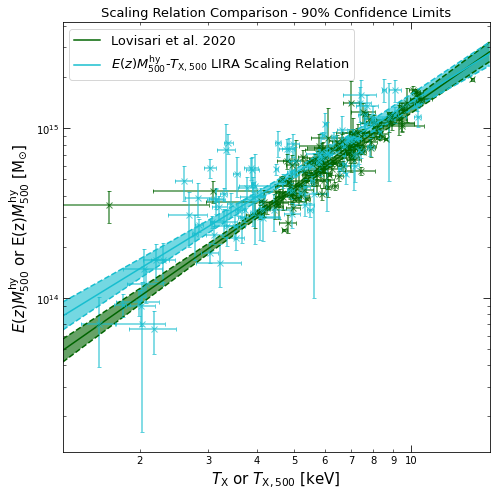

/Users/dt237/code/XGA/xga/products/relation.py:1073: UserWarning: Not all of these ScalingRelations have the same x-axis names.
  warn('Not all of these ScalingRelations have the same x-axis names.')
/Users/dt237/code/XGA/xga/products/relation.py:1080: UserWarning: Not all of these ScalingRelations have the same y-axis names.
  warn('Not all of these ScalingRelations have the same y-axis names.')


Removed no burn in
Removed no burn in


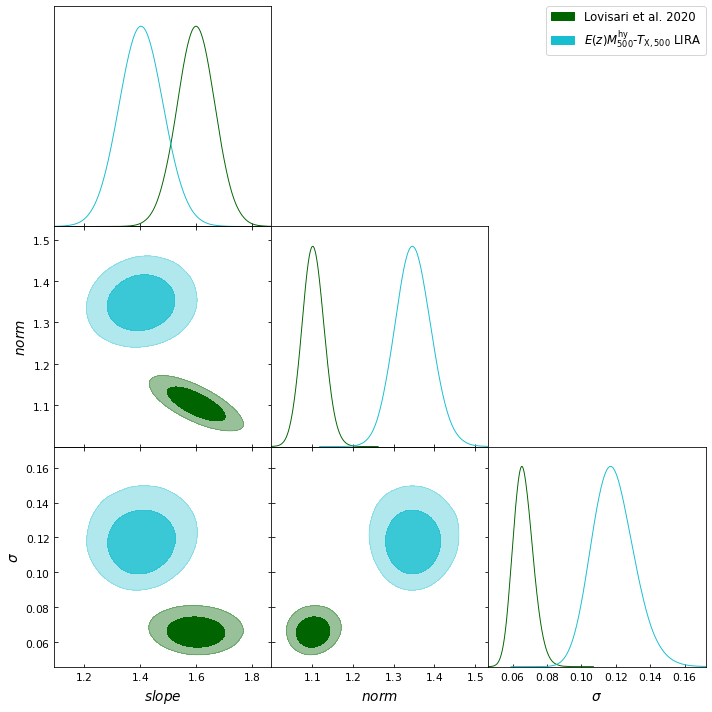

In [28]:
(lmt+sdss_mt_wre).view(figsize=(7, 7))
(lmt+sdss_mt_wre).view_corner()

In [43]:
testo

,name,MEM_MATCH_ID,z,richness,richness_err,Tx_500,Tx_500-,Tx_500+,Lx52_500,Lx52_500-,...,Mhy500_wraderr+,Mg500_wraderr,Mg500_wraderr-,Mg500_wraderr+,Mhy2500_wraderr,Mhy2500_wraderr-,Mhy2500_wraderr+,Mg2500_wraderr,Mg2500_wraderr-,Mg2500_wraderr+
0,SDSSXCS-124,124,0.247483,109.550186,4.489680,6.92015,0.116366,0.111646,5.310395e+44,2.513830e+42,...,1.041261,0.870390,0.015662,0.016223,2.621462,0.113380,0.138668,0.321697,0.007076,0.007250
1,SDSSXCS-2789,2789,0.105285,38.904396,2.830206,4.53982,0.073019,0.074566,1.029585e+44,6.177372e+41,...,1.456225,0.218499,0.002874,0.002963,1.602810,0.102195,0.110153,0.097399,0.001819,0.001737
2,SDSSXCS-290,290,0.348495,105.095730,5.994321,5.31695,0.297861,0.336333,2.856685e+44,5.981212e+42,...,0.420849,0.427478,0.019454,0.019887,1.469441,0.177871,0.288247,0.134133,0.005839,0.005993
3,SDSSXCS-1018,1018,0.214403,56.996796,3.219202,3.90154,0.143535,0.151506,8.044820e+43,8.099825e+41,...,0.973924,0.210059,0.003374,0.003431,1.128619,0.104011,0.149860,0.084350,0.002327,0.002330
4,SDSSXCS-134,134,0.277304,108.604380,4.792484,6.72636,0.116529,0.116561,4.811889e+44,2.353605e+42,...,0.781372,0.767157,0.010866,0.010814,3.042067,0.125878,0.124549,0.313911,0.007265,0.007068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143,SDSSXCS-34,34,0.300713,20.033995,3.873894,3.51423,0.206020,0.217709,8.633458e+43,1.939628e+42,...,0.376983,0.286297,0.013940,0.013461,0.617065,0.077543,0.078922,0.066970,0.004087,0.004046
144,SDSSXCS-11154,11154,0.160062,29.064940,2.978542,4.15448,0.125320,0.125168,1.691834e+44,1.880848e+42,...,0.338649,0.393123,0.011202,0.010895,1.041306,0.090935,0.098537,0.111631,0.003300,0.003317
147,SDSSXCS-68,68,0.300570,126.330660,4.886888,7.21801,0.216922,0.242930,5.482636e+44,5.676998e+42,...,0.797112,0.866319,0.019615,0.019060,2.925836,0.214431,0.224624,0.309140,0.011104,0.010986
148,SDSSXCS-147,147,0.259350,104.470276,4.512718,6.64643,0.183147,0.183515,2.494743e+44,2.037780e+42,...,1.854716,0.558438,0.007220,0.007275,2.090275,0.123725,0.133519,0.203258,0.005389,0.005588


In [44]:
e = cosmo.efunc(testo['z'].values)
ms = Quantity(testo[['Mhy500_wraderr', 'Mhy500_wraderr-', 'Mhy500_wraderr+']]*1e+14, 'Msun')*e[..., None]**2
ls = Quantity(testo[['Lx52_500', 'Lx52_500-', 'Lx52_500+']], 'erg/s')
sdss_ml = scaling_relation_lira(ms[:, 0], ms[:, 1:], ls[:, 0], ls[:, 1:], m_norm, lml.x_norm, 
                                y_name=r'$E(z)^{2}M^{\rm{hy}}_{500}$', x_name=r'$L^{52}_{\rm{X,500}}$')
sdss_ml.model_colour = 'tab:cyan'

  |**************************************************| 100%


In [46]:
e = cosmo.efunc(testo['z'].values)
ms = Quantity(testo[['Mhy500_wraderr', 'Mhy500_wraderr-', 'Mhy500_wraderr+']]*1e+14, 'Msun')
ls = Quantity(testo[['Lx52_500', 'Lx52_500-', 'Lx52_500+']], 'erg/s')*e[..., None]**(-2)
sdss_lm = scaling_relation_lira(ls[:, 0], ls[:, 1:], ms[:, 0], ms[:, 1:], lml.x_norm, m_norm, 
                                x_name=r'$M^{\rm{hy}}_{500}$', y_name=r'$E(z)^{-2}L^{52}_{\rm{X,500}}$')
sdss_lm.model_colour = 'tab:cyan'

  |**************************************************| 100%


/Users/dt237/code/XGA/xga/products/relation.py:827: UserWarning: The 'show_third_dim' argument should only be set to True if 'third_dim_info' was set on the creation of this scaling relation. Setting 'show_third_im' to False.
  warn("The 'show_third_dim' argument should only be set to True if 'third_dim_info' was set on the creation "


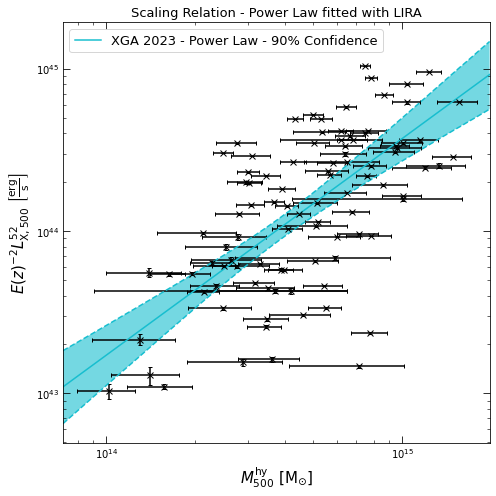

In [49]:
sdss_lm.view(figsize=(7, 7), save_path="sdsslm_r500.pdf")

Removed no burn in


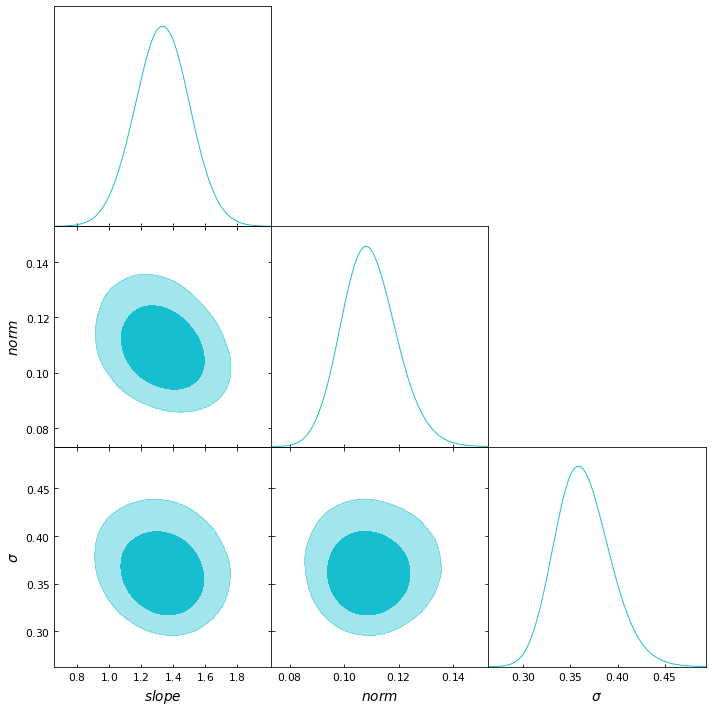

In [48]:
sdss_lm.view_corner()

In [53]:
e = cosmo.efunc(testo['z'].values)
ms = Quantity(testo[['Mhy2500_wraderr', 'Mhy2500_wraderr-', 'Mhy2500_wraderr+']]*1e+14, 'Msun')
ls = Quantity(testo[['Lx52_2500', 'Lx52_2500-', 'Lx52_2500+']], 'erg/s')*e[..., None]**(-2)
sdss_lm2500 = scaling_relation_lira(ls[:, 0], ls[:, 1:], ms[:, 0], ms[:, 1:], lml.x_norm, Quantity(1e+14, 'Msun'), 
                                x_name=r'$M^{\rm{hy}}_{2500}$', y_name=r'$E(z)^{-2}L^{52}_{\rm{X,2500}}$')
sdss_lm2500.model_colour = 'tab:cyan'

/Users/dt237/code/XGA/xga/relations/fit.py:83: UserWarning: 13 sources have NaN values and have been excluded
  warn("{} sources have NaN values and have been excluded".format(thrown_away))


  |**************************************************| 100%


/Users/dt237/code/XGA/xga/products/relation.py:827: UserWarning: The 'show_third_dim' argument should only be set to True if 'third_dim_info' was set on the creation of this scaling relation. Setting 'show_third_im' to False.
  warn("The 'show_third_dim' argument should only be set to True if 'third_dim_info' was set on the creation "


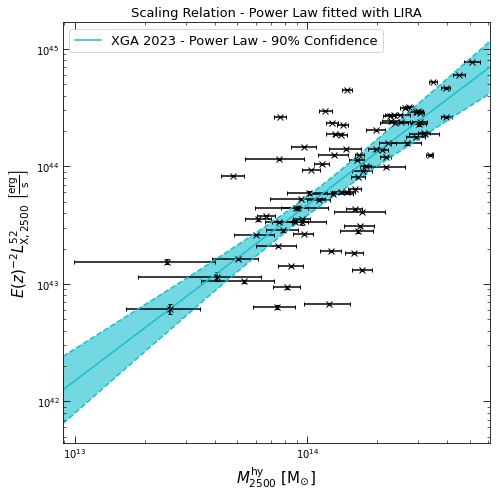

In [55]:
sdss_lm2500.view(figsize=(7, 7), save_path="sdsslm_r2500.pdf")

In [ ]:
e = cosmo.efunc(sdssrm_plotting['z'].values)
ms = Quantity(sdssrm_plotting[['Mhy', 'Mhy-', 'Mhy+']]*1e+14, 'Msun')*e[..., None]**2
ls = Quantity(sdssrm_plotting[['Lx', 'Lx-', 'Lx+']], 'erg/s')
cut_arr = np.where(ls[:, 0] > lml.x_data.min())[0]
sdss_ml_cut = scaling_relation_lira(ms[cut_arr, 0], ms[cut_arr, 1:], ls[cut_arr, 0], ls[cut_arr, 1:], m_norm, 
                                    lml.x_norm, y_name=r'$E(z)^{2}M^{\rm{hy}}_{500}$', 
                                    x_name=r'$L^{52}_{\rm{X,500}}$')
sdss_ml_cut.model_colour = 'tab:cyan'

In [ ]:
l_norm

In [ ]:
print(lml.x_norm)
print(lml.y_norm)

In [ ]:
(lml+sdss_ml_cut).view(figsize=(7, 7))

In [ ]:
(lml+sdss_ml_cut).view_corner()

In [36]:
e = cosmo.efunc(comb['z'].values)

ms = Quantity(comb[['Mhy500_wraderr', 'Mhy500_wraderr-', 'Mhy500_wraderr+']]*1e+14, 'Msun')*e[..., None]
rs = Quantity(comb[['richness', 'richness_err']], '')
sdss_mr = scaling_relation_lira(ms[:, 0], ms[:, 1:], rs[:, 0], rs[:, 1], m_norm, Quantity(40), 
                                y_name=r'$M^{\rm{hy}}_{500}$', x_name=r'$\lambda$')
sdss_mr.model_colour = 'indigo'

  |**************************************************| 100%


/Users/dt237/code/XGA/xga/products/relation.py:827: UserWarning: The 'show_third_dim' argument should only be set to True if 'third_dim_info' was set on the creation of this scaling relation. Setting 'show_third_im' to False.
  warn("The 'show_third_dim' argument should only be set to True if 'third_dim_info' was set on the creation "


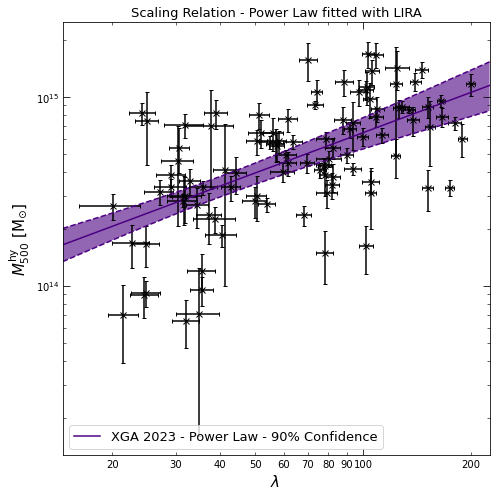

Removed no burn in


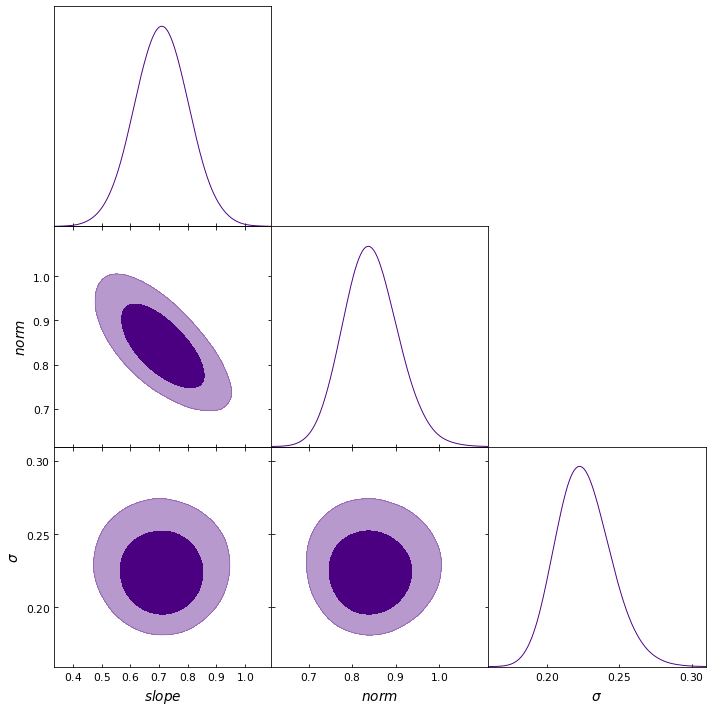

In [37]:
sdss_mr.view(figsize=(7, 7), save_path='sdssmr_r500.pdf')
sdss_mr.view_corner()

In [38]:
e = cosmo.efunc(comb['z'].values)

ms = Quantity(comb[['Mhy2500_wraderr', 'Mhy2500_wraderr-', 'Mhy2500_wraderr+']]*1e+14, 'Msun')*e[..., None]
rs = Quantity(comb[['richness', 'richness_err']], '')
sdss_mr2500 = scaling_relation_lira(ms[:, 0], ms[:, 1:], rs[:, 0], rs[:, 1], m_norm, Quantity(40), 
                                y_name=r'$M^{\rm{hy}}_{2500}$', x_name=r'$\lambda$')
sdss_mr2500.model_colour = 'indigo'

/Users/dt237/code/XGA/xga/relations/fit.py:83: UserWarning: 13 sources have NaN values and have been excluded
  warn("{} sources have NaN values and have been excluded".format(thrown_away))


  |**************************************************| 100%


/Users/dt237/code/XGA/xga/products/relation.py:827: UserWarning: The 'show_third_dim' argument should only be set to True if 'third_dim_info' was set on the creation of this scaling relation. Setting 'show_third_im' to False.
  warn("The 'show_third_dim' argument should only be set to True if 'third_dim_info' was set on the creation "


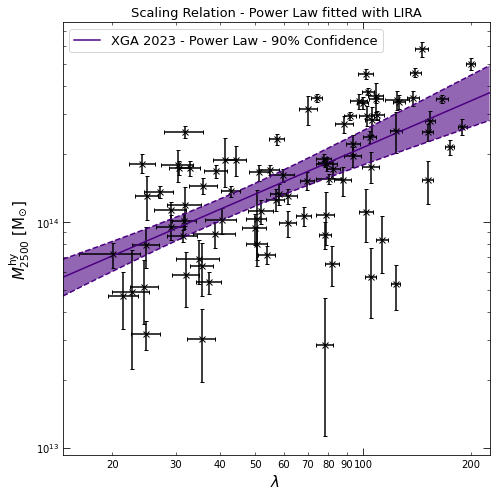

Removed no burn in


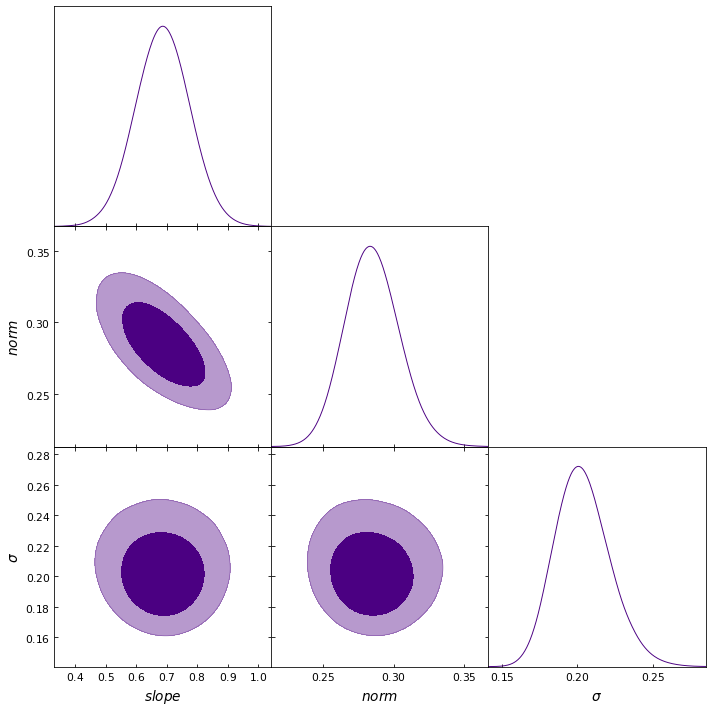

In [39]:
sdss_mr2500.view(figsize=(7, 7), save_path='sdssmr_r2500.pdf')
sdss_mr2500.view_corner()

In [59]:
comb.columns

Index(['name', 'MEM_MATCH_ID', 'z', 'richness', 'richness_err', 'Tx_500',
       'Tx_500-', 'Tx_500+', 'Lx52_500', 'Lx52_500-', 'Lx52_500+', 'Lxbol_500',
       'Lxbol_500-', 'Lxbol_500+', 'Tx_2500', 'Tx_2500-', 'Tx_2500+',
       'Lx52_2500', 'Lx52_2500-', 'Lx52_2500+', 'Lxbol_2500', 'Lxbol_2500-',
       'Lxbol_2500+', 'Mhy500', 'Mhy500-', 'Mhy500+', 'Mg500', 'Mg500-',
       'Mg500+', 'Mhy2500', 'Mhy2500-', 'Mhy2500+', 'Mg2500', 'Mg2500-',
       'Mg2500+', 'Mhy500_wraderr', 'Mhy500_wraderr-', 'Mhy500_wraderr+',
       'Mg500_wraderr', 'Mg500_wraderr-', 'Mg500_wraderr+', 'Mhy2500_wraderr',
       'Mhy2500_wraderr-', 'Mhy2500_wraderr+', 'Mg2500_wraderr',
       'Mg2500_wraderr-', 'Mg2500_wraderr+'],
      dtype='object')

In [60]:
e = cosmo.efunc(comb['z'].values)

ms = Quantity(comb[['Mg500_wraderr', 'Mg500_wraderr-', 'Mg500_wraderr+']]*1e+14, 'Msun')*e[..., None]
rs = Quantity(comb[['richness', 'richness_err']], '')
sdss_gmr = scaling_relation_lira(ms[:, 0], ms[:, 1:], rs[:, 0], rs[:, 1], m_norm, Quantity(40), 
                                y_name=r'$M^{\rm{gas}}_{500}$', x_name=r'$\lambda$')
sdss_gmr.model_colour = 'indigo'

  |**************************************************| 100%


/Users/dt237/code/XGA/xga/products/relation.py:827: UserWarning: The 'show_third_dim' argument should only be set to True if 'third_dim_info' was set on the creation of this scaling relation. Setting 'show_third_im' to False.
  warn("The 'show_third_dim' argument should only be set to True if 'third_dim_info' was set on the creation "


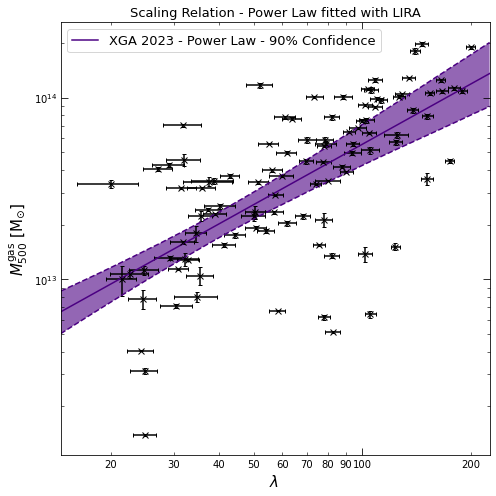

In [67]:
sdss_gmr.view(figsize=(7, 7), save_path='sdssgmr_r500.pdf')

In [63]:
e = cosmo.efunc(comb['z'].values)

ms = Quantity(comb[['Mg2500_wraderr', 'Mg2500_wraderr-', 'Mg2500_wraderr+']]*1e+14, 'Msun')*e[..., None]
rs = Quantity(comb[['richness', 'richness_err']], '')
sdss_gmr2500 = scaling_relation_lira(ms[:, 0], ms[:, 1:], rs[:, 0], rs[:, 1], m_norm, Quantity(40), 
                                y_name=r'$M^{\rm{gas}}_{2500}$', x_name=r'$\lambda$')
sdss_gmr2500.model_colour = 'indigo'

/Users/dt237/code/XGA/xga/relations/fit.py:83: UserWarning: 13 sources have NaN values and have been excluded
  warn("{} sources have NaN values and have been excluded".format(thrown_away))


  |**************************************************| 100%


/Users/dt237/code/XGA/xga/products/relation.py:827: UserWarning: The 'show_third_dim' argument should only be set to True if 'third_dim_info' was set on the creation of this scaling relation. Setting 'show_third_im' to False.
  warn("The 'show_third_dim' argument should only be set to True if 'third_dim_info' was set on the creation "


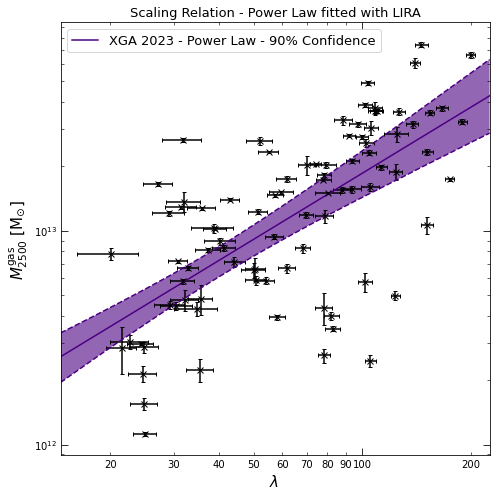

In [66]:
sdss_gmr2500.view(figsize=(7, 7), save_path='sdssgmr_r2500.pdf')

In [40]:
amr._x_name = r'$\lambda$'
amr._y_name = r'$M^{hy}$'
sdss_mr._y_name = r'$M^{hy}$'

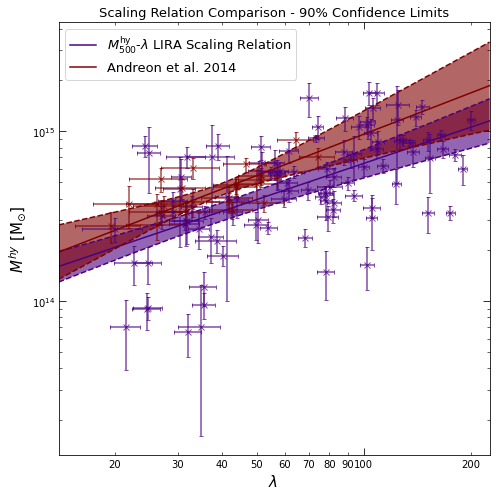

In [41]:
(sdss_mr+amr).view(figsize=(7, 7), save_path='sdss+andreon_mr.pdf')

Removed no burn in
Removed no burn in


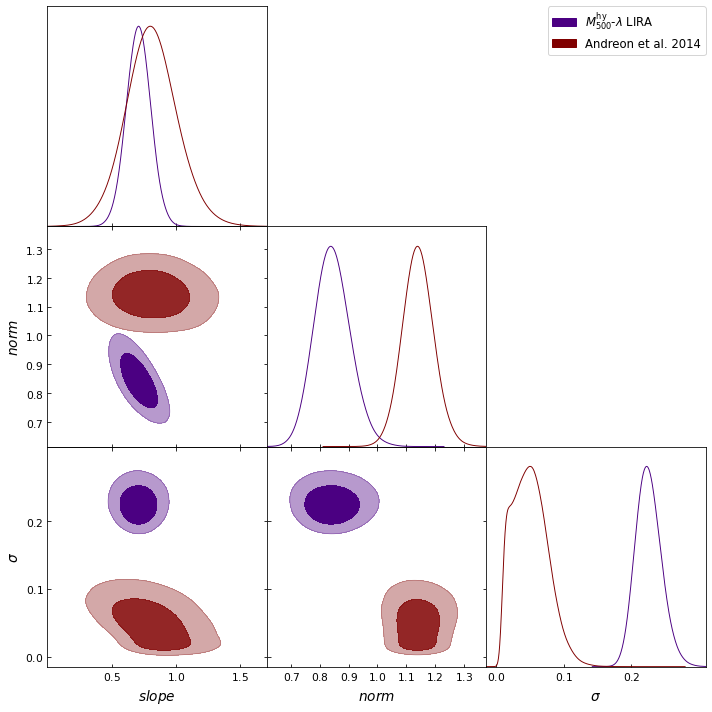

In [42]:
(sdss_mr+amr).view_corner()

In [68]:
testo.columns

Index(['name', 'MEM_MATCH_ID', 'z', 'richness', 'richness_err', 'Tx_500',
       'Tx_500-', 'Tx_500+', 'Lx52_500', 'Lx52_500-', 'Lx52_500+', 'Lxbol_500',
       'Lxbol_500-', 'Lxbol_500+', 'Tx_2500', 'Tx_2500-', 'Tx_2500+',
       'Lx52_2500', 'Lx52_2500-', 'Lx52_2500+', 'Lxbol_2500', 'Lxbol_2500-',
       'Lxbol_2500+', 'Mhy500', 'Mhy500-', 'Mhy500+', 'Mg500', 'Mg500-',
       'Mg500+', 'Mhy2500', 'Mhy2500-', 'Mhy2500+', 'Mg2500', 'Mg2500-',
       'Mg2500+', 'Mhy500_wraderr', 'Mhy500_wraderr-', 'Mhy500_wraderr+',
       'Mg500_wraderr', 'Mg500_wraderr-', 'Mg500_wraderr+', 'Mhy2500_wraderr',
       'Mhy2500_wraderr-', 'Mhy2500_wraderr+', 'Mg2500_wraderr',
       'Mg2500_wraderr-', 'Mg2500_wraderr+'],
      dtype='object')

In [71]:
e = cosmo.efunc(testo['z'].values)
gms = Quantity(testo[['Mg500_wraderr', 'Mg500_wraderr-', 'Mg500_wraderr+']]*1e+14, 'Msun')
ls = Quantity(testo[['Lx52_500', 'Lx52_500-', 'Lx52_500+']], 'erg/s')*e[..., None]**(-2)
sdss_lgm = scaling_relation_lira(ls[:, 0], ls[:, 1:], gms[:, 0], gms[:, 1:], lml.x_norm, Quantity(4e+13, 'Msun'), 
                                x_name=r'$M^{\rm{gas}}_{500}$', y_name=r'$E(z)^{-2}L^{52}_{\rm{X,500}}$')
sdss_lgm.model_colour = 'tab:cyan'

  |**************************************************| 100%


/Users/dt237/code/XGA/xga/products/relation.py:827: UserWarning: The 'show_third_dim' argument should only be set to True if 'third_dim_info' was set on the creation of this scaling relation. Setting 'show_third_im' to False.
  warn("The 'show_third_dim' argument should only be set to True if 'third_dim_info' was set on the creation "


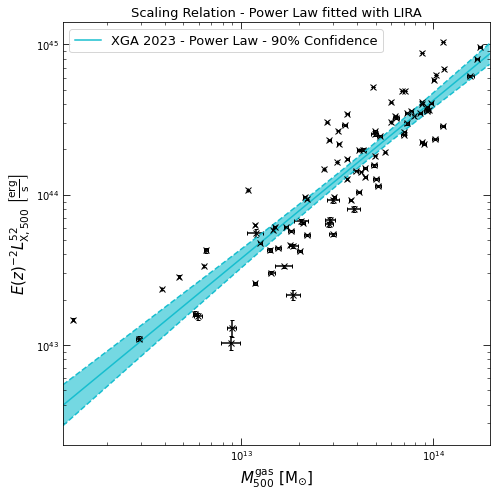

In [72]:
sdss_lgm.view(figsize=(7, 7))

In [73]:
e = cosmo.efunc(testo['z'].values)
gms = Quantity(testo[['Mg2500_wraderr', 'Mg2500_wraderr-', 'Mg2500_wraderr+']]*1e+14, 'Msun')
ls = Quantity(testo[['Lx52_2500', 'Lx52_2500-', 'Lx52_2500+']], 'erg/s')*e[..., None]**(-2)
sdss_lgm2500 = scaling_relation_lira(ls[:, 0], ls[:, 1:], gms[:, 0], gms[:, 1:], lml.x_norm, Quantity(4e+13, 'Msun'), 
                                x_name=r'$M^{\rm{gas}}_{2500}$', y_name=r'$E(z)^{-2}L^{52}_{\rm{X,2500}}$')
sdss_lgm2500.model_colour = 'tab:cyan'

/Users/dt237/code/XGA/xga/relations/fit.py:83: UserWarning: 13 sources have NaN values and have been excluded
  warn("{} sources have NaN values and have been excluded".format(thrown_away))


  |**************************************************| 100%


/Users/dt237/code/XGA/xga/products/relation.py:827: UserWarning: The 'show_third_dim' argument should only be set to True if 'third_dim_info' was set on the creation of this scaling relation. Setting 'show_third_im' to False.
  warn("The 'show_third_dim' argument should only be set to True if 'third_dim_info' was set on the creation "


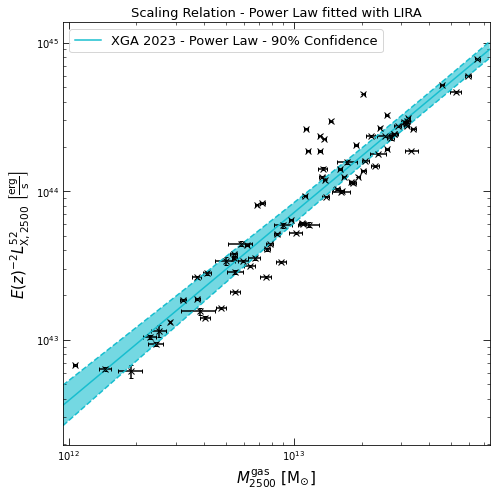

In [74]:
sdss_lgm2500.view(figsize=(7, 7))